# Cash Flow Terminator Tutorial

## Introduction

This document explains how to use the Cash Flow Terminator endpoints of the **Private Equity Model API** provided by [prettymodels.ai](https://prettymodels.ai). Our proprietary model is based on publications by [De Malherbe (2004)](https://doi.org/10.1142/S0219024904002359) and [Buchner (2017)](https://doi.org/10.21314/JOR.2017.363).

## Setup Python and API keys

In [1]:
# Load packages
import os
import requests
import pandas as pd

In [2]:
# Define the API root URL

# EVERY USER NEEDS TO DO THIS !!!

base_product_url = "https://base-product-url.app"
primary_api_key = "needed-for-authentication"
secondary_api_key = "needed-for-authentication"

if (base_product_url == "https://base-product-url.app"):
    print("IMPORTANT: You need to MANUALLY set the correct base_product_url and primary_api_key!")
    from api_root import primary_api_key, secondary_api_key, base_product_url

IMPORTANT: You need to MANUALLY set the correct base_product_url and primary_api_key!


## Available endpoints in the CFT module

In [3]:
# CASH FLOW TERMINATOR MODEL
model = "cft_23/user_assumptions"

endpoints = [
    "cash_flow_expectations",
    "cash_flow_quantiles?quantile=0.1",
    "cash_flow_quantiles?quantile=0.5",
    "cash_flow_quantiles?quantile=0.9",
    "cash_flow_paths",
]

## Check available fund segments and macro environments

In [4]:
# Check available fund_segments and macro_environments (directly from the API)

fund_segments = requests.get(os.path.join(base_product_url, "common/fund_segments"))
print("fund_segments", fund_segments.json())
macro_environments = requests.get(
    os.path.join(base_product_url, "common/macro_environments")
)
print("macro_environments", macro_environments.json())

fund_segments ['BO', 'VC', 'PE', 'RE', 'PD', 'INF', 'NATRES', 'FOF']
macro_environments ['average', 'medium', 'super', 'good', 'bad', 'evil']


## Define the API request body

Our Cash Flow Terminator model has the following parameters:

Specify your input parameters in the request body:

-   Performance:
    -   **fund\_segment**: choose from \[BO, VC, PE, RE, PD, INF, NATRES, FOF\]
    -   **macro\_environment**: choose from \[average, medium, super, good, bad, evil\]
    -   **annualized\_alpha**: systematic fund outperformance (0.01 corresponds to 1% annual excess return)
-   Timing:
    -   **start\_age**: between 0 and 20 years
    -   **expected\_investment\_period**: usually investment period ends after 4-6 years
    -   **expected\_fund\_age**: usually PE funds are liquidated after 10-15 years
-   Commitment:
    -   **commitment**: non-negative float
    -   **open\_commitment**: non-negative float
    -   **recallable**: non-negative float
    -   **overdraw\_percentage**: how many percentage of the commitment are additionally called
    -   **recallable\_percentage**: how many percentage of the commitment can be maximally recalled
-   Start Cash Flows:
    -   **cum\_contributions**: non-negative float
    -   **cum\_distributions**: non-negative float
    -   **net\_cash\_flow**: non-negative float
    -   **nav** (net asset value): non-negative float

**Please enter your own parameter assumptions!**


In [5]:
# Define the data to be sent in the request body (as a dictionary)
request_body = {
    "fund_segment": fund_segments.json()[0],
    "start_age": 0,
    "macro_environment": macro_environments.json()[0],
    "cum_contributions": 0,
    "cum_distributions": 0,
    "net_cash_flow": 0,
    "nav": 0,
    "commitment": 100,
    "open_commitment": 100,
    "annualized_alpha": 0,
    "overdraw_percentage": 0,
    "recallable_percentage": 0,
    "recallable": 0,
    "expected_investment_period": 5,
    "expected_fund_age": 12,
}

## Run the API requests

POST request successful: cash_flow_expectations
POST request successful: cash_flow_quantiles?quantile=0.1
POST request successful: cash_flow_quantiles?quantile=0.5
POST request successful: cash_flow_quantiles?quantile=0.9
POST request successful: cash_flow_paths


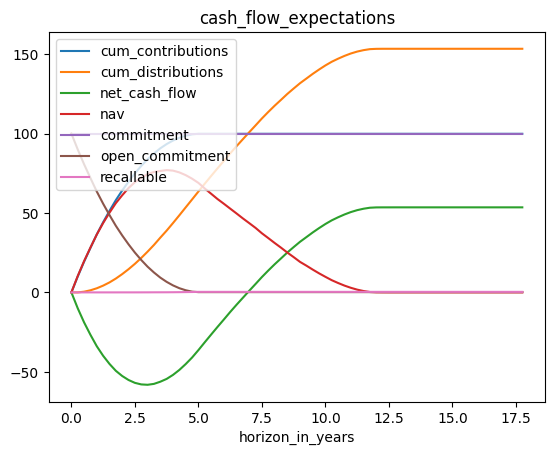

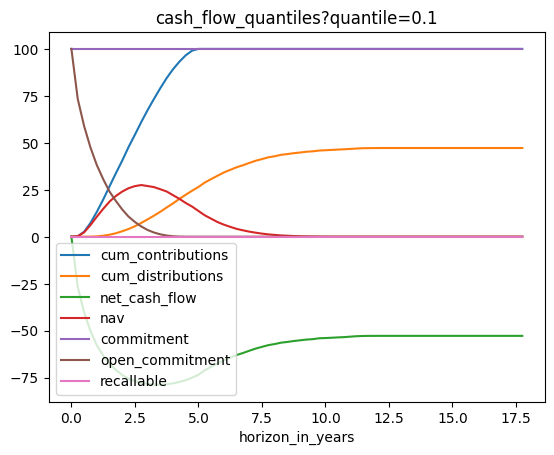

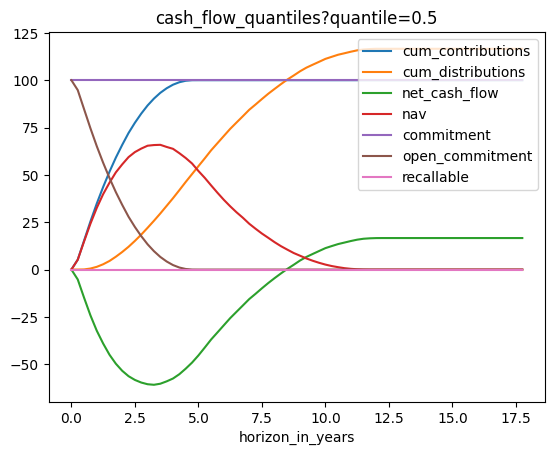

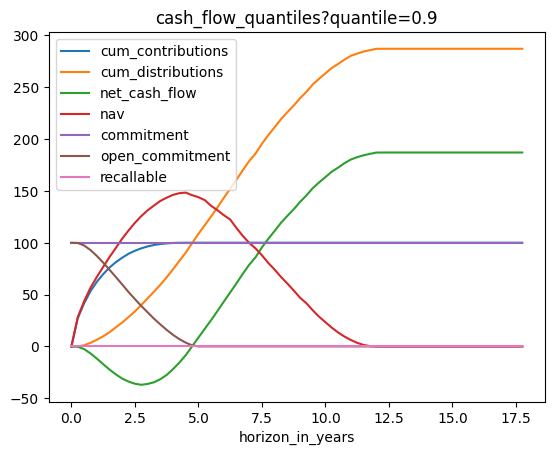

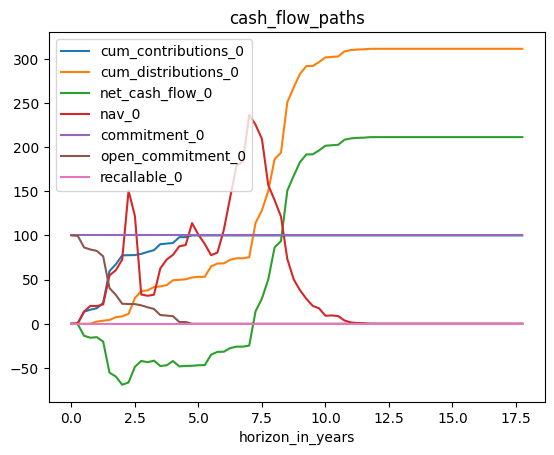

In [6]:
# Request all endpoints

for endpoint in endpoints:
    # Build API URL
    url = os.path.join(base_product_url, model, endpoint)

    # Set header for authentication
    headers = {"X-BLOBR-KEY": primary_api_key}

    # Send the POST request
    response = requests.post(url, json=request_body, headers=headers)

    if response.status_code == 401:
        # needed for API Key Rotation
        # More info: https://www.blobr.io/post/api-keys-best-practices
        headers = {"X-BLOBR-KEY": secondary_api_key}
        response = requests.post(url, json=request_body, headers=headers)

    # Check the response status code
    if response.status_code == 200:
        # Request was successful
        print(f"POST request successful: {endpoint}")
        # print("Response JSON:", response.json())
    else:
        # Request failed
        print("POST request failed with status code:", response.status_code)

    # Convert dict to pd.DataFrame
    df = pd.DataFrame(response.json())
    df.index.name = "horizon_in_years"
    # print("df", df.columns, df)

    # Save pd.DataFrame to .csv file
    df.to_csv(f"cash_flow_terminator---{endpoint}.csv")
    
    if endpoint == "cash_flow_paths":
        # just select the first scenario for plotting (otherwise it looks messy)
        df = df.filter(like='_0', axis=1)
        
    plot = df.plot(title=endpoint)

